In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  7 22:49:16 2019

@author: RedFox GIS & Remote Sensing, Aaron P.
"""
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from matplotlib import pyplot as plt
from rasterio.plot import show, show_hist
from rasterio.features import shapes
from skimage.segmentation import quickshift, mark_boundaries
from skimage import io, color
from rasterstats import zonal_stats
import geopandas as gpd
from shapely.geometry import shape
from sklearn.ensemble import RandomForestClassifier

In [2]:
indata = '/river_subset.tif'
training_data = '/training_data.shp'
outdata = '/RF_results.shp'

## Read image and calculate statistics

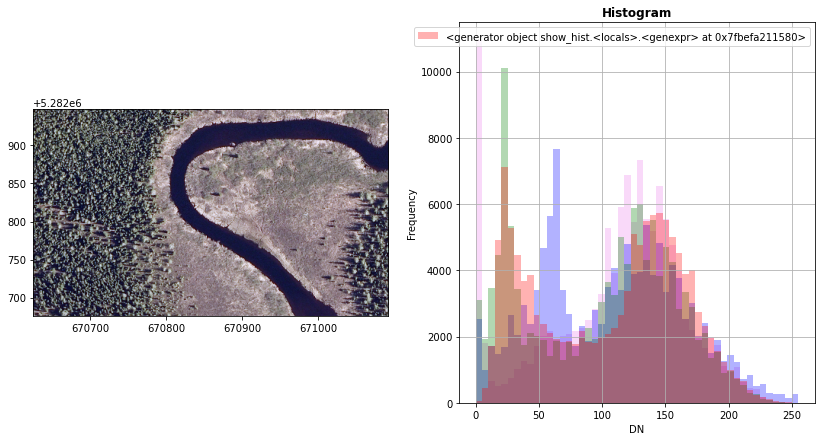

In [3]:
# Read in 4 band NAIP image
dataset = rasterio.open(indata)

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show(dataset, ax=axrgb)
show_hist(dataset, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

# Get image bounding box info
sr = dataset.crs
bounds = dataset.bounds
affine = dataset.transform#.to_gdal()

    


## Segment Image

Quickshift number of segments: 406


<ipython-input-4-a12da3830f8a>:7: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(segments, img))
/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/skimage/color/colorlabel.py:168: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = img_as_float(rgb2gray(image))


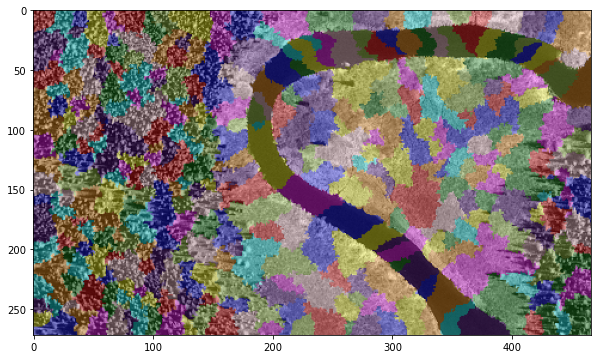

In [4]:
img = io.imread(indata)
segments = quickshift(img, kernel_size=3, convert2lab=False, max_dist=6, ratio=0.5).astype('int32')
print("Quickshift number of segments: %d" % len(np.unique(segments)))

# View the segments via Python
plt.figure(figsize=(10,10))
plt.imshow(color.label2rgb(segments, img))

## Calculate NDVI

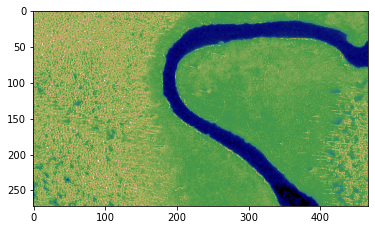

<AxesSubplot:>

In [5]:
red = dataset.read(3).astype(float)
nir = dataset.read(4).astype(float)

#Allow 0 in division
np.seterr(divide='ignore', invalid='ignore')

ndvi = np.empty(dataset.shape, dtype=rasterio.float32)
check = np.logical_or ( red > 0, nir > 0 )
ndvi = np.where ( check,  (nir - red ) / ( nir + red ), -999 )
show(ndvi, cmap='gist_earth')

## Calculate zonal statistics

In [6]:
polys = []
for shp, value in shapes(segments, transform=affine):
    polys.append(shp)

ndvi_mean = zonal_stats(polys, ndvi, affine = affine, stats="mean")
red_mean = zonal_stats(polys, dataset.read(1), affine = affine, stats="mean")
green_mean = zonal_stats(polys, dataset.read(2), affine = affine, stats="mean")
blue_mean = zonal_stats(polys, dataset.read(3), affine = affine, stats="mean")
nir_mean = zonal_stats(polys, dataset.read(4), affine = affine, stats="mean")



/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


## Convert segments to geodataframe

In [7]:
geom = [shape(i) for i in polys]
polys_gdf = gpd.GeoDataFrame({'geometry':geom})

## Add metrics to geodataframe

In [8]:
# NDVI
# Add a ndvi field and calculate mean value
ndvi_series = pd.Series([f['mean'] for f in ndvi_mean])
polys_gdf['ndvi'] = ndvi_series.values

# RGBnIR
red_series = pd.Series([f['mean'] for f in red_mean])
polys_gdf['red_mean'] = red_series.values

green_series = pd.Series([f['mean'] for f in green_mean])
polys_gdf['green_mean'] = green_series.values

blue_series = pd.Series([f['mean'] for f in blue_mean])
polys_gdf['blue_mean'] = blue_series.values

nir_series = pd.Series([f['mean'] for f in nir_mean])
polys_gdf['nir_mean'] = nir_series.values




In [9]:
# Check results
polys_gdf

,geometry,ndvi,red_mean,green_mean,blue_mean,nir_mean
0,"POLYGON ((670625.002 5282947.795, 670625.002 5...",0.359136,85.554455,86.514851,86.019802,141.376238
1,"POLYGON ((670871.002 5282947.795, 670871.002 5...",-0.080569,168.947090,153.579365,159.925926,134.383598
2,"POLYGON ((670971.002 5282947.795, 670971.002 5...",-0.018852,161.146119,147.310502,148.114155,139.972603
3,"POLYGON ((670992.002 5282947.795, 670992.002 5...",-0.056795,180.982533,164.231441,168.196507,145.624454
4,"POLYGON ((670923.002 5282947.795, 670923.002 5...",-0.046072,143.475000,126.758333,132.129167,118.408333
...,...,...,...,...,...,...
481,"POLYGON ((670898.002 5282694.795, 670898.002 5...",-0.034642,154.750000,138.368421,142.347368,131.247368
482,"POLYGON ((670913.002 5282699.795, 670913.002 5...",-0.020341,164.096606,148.898172,149.524804,142.148825
483,"POLYGON ((670995.002 5282699.795, 670995.002 5...",-0.911014,37.395620,27.310949,63.919708,4.029197
484,"POLYGON ((671055.002 5282702.795, 671055.002 5...",-0.098643,67.272206,60.510029,79.200573,64.418338


## Generate training Data

In [10]:
# Read in shapefile with ground truth classes
gdf = gpd.read_file(training_data)

class_names = gdf['label'].unique()

# Assign integer to class names
class_ids = np.arange(class_names.size) + 1

# Add a new column and assign integer value to correspoding label
gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))

# Spatial Join
data = gpd.sjoin(gdf, polys_gdf, how='left')

data.head()

<ipython-input-10-f31ce2ce2b72>:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:26915
Right CRS: None

  data = gpd.sjoin(gdf, polys_gdf, how='left')


,id,label,geometry,index_right,ndvi,red_mean,green_mean,blue_mean,nir_mean
0,1,forest,POINT (670655.345 5282861.972),163,0.281459,68.232258,71.600000,77.438710,111.361290
1,1,forest,POINT (670756.515 5282891.345),116,0.249655,66.337209,68.666667,78.426357,110.112403
2,1,forest,POINT (670761.003 5282933.771),25,0.300445,60.284507,63.952113,73.157746,105.969014
3,1,forest,POINT (670646.778 5282934.179),20,0.337188,80.356322,82.465517,81.827586,133.037356
4,1,forest,POINT (670651.266 5282748.564),364,0.166562,40.459459,40.585586,56.045045,75.144144


## Split data into train and test sets

In [11]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

x = data[['ndvi', 'red_mean', 'green_mean', 'blue_mean', 'nir_mean']]
y = data[['id']]

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # 70% training and 30% test

In [12]:
x.head()

,ndvi,red_mean,green_mean,blue_mean,nir_mean
0,0.281459,68.232258,71.600000,77.438710,111.361290
1,0.249655,66.337209,68.666667,78.426357,110.112403
2,0.300445,60.284507,63.952113,73.157746,105.969014
3,0.337188,80.356322,82.465517,81.827586,133.037356
4,0.166562,40.459459,40.585586,56.045045,75.144144


## Classify

In [13]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a RF Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train.values.ravel())

y_pred=clf.predict(x_test)

In [14]:
y_pred

array([2, 2, 2, 1, 1, 3, 2, 1, 3, 3, 2, 1, 2, 1, 3, 3, 2, 1])

In [15]:
x_test

,ndvi,red_mean,green_mean,blue_mean,nir_mean
38,-0.748218,35.304202,31.078992,64.443697,13.400000
37,-0.727688,38.795580,30.997238,63.497238,12.361878
33,-0.763750,36.307317,28.882927,62.231707,9.860976
5,0.294902,63.355263,64.644737,72.927632,102.671053
14,0.223039,69.372973,71.675676,80.837838,105.489189
43,-0.052110,167.161572,152.039301,156.528384,139.493450
24,-0.790774,29.748654,23.675045,58.046679,6.759425
6,0.183364,55.819417,57.168932,69.225243,91.368932
54,0.015588,148.712982,137.100406,137.550710,139.709939
41,-0.056837,148.798039,132.907843,138.088235,121.003922


## Assess Accuracy

In [16]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9444444444444444


## Assess feature importance

In [17]:
# https://www.datacamp.com/community/tutorials/random-forests-classifier-python





## Predict on all segments

In [18]:
# Get the original data and convert to 2-D array
data2 = pd.DataFrame(polys_gdf[['ndvi', 'red_mean', 'green_mean', 'blue_mean', 'nir_mean']])

# Predict
y2_pred=clf.predict(data2) # Creates an array of predictions

# Append predict array to geopandas gdf
polys_gdf['class'] = y2_pred

In [19]:
polys_gdf

,geometry,ndvi,red_mean,green_mean,blue_mean,nir_mean,class
0,"POLYGON ((670625.002 5282947.795, 670625.002 5...",0.359136,85.554455,86.514851,86.019802,141.376238,1
1,"POLYGON ((670871.002 5282947.795, 670871.002 5...",-0.080569,168.947090,153.579365,159.925926,134.383598,3
2,"POLYGON ((670971.002 5282947.795, 670971.002 5...",-0.018852,161.146119,147.310502,148.114155,139.972603,3
3,"POLYGON ((670992.002 5282947.795, 670992.002 5...",-0.056795,180.982533,164.231441,168.196507,145.624454,3
4,"POLYGON ((670923.002 5282947.795, 670923.002 5...",-0.046072,143.475000,126.758333,132.129167,118.408333,3
...,...,...,...,...,...,...,...
481,"POLYGON ((670898.002 5282694.795, 670898.002 5...",-0.034642,154.750000,138.368421,142.347368,131.247368,3
482,"POLYGON ((670913.002 5282699.795, 670913.002 5...",-0.020341,164.096606,148.898172,149.524804,142.148825,3
483,"POLYGON ((670995.002 5282699.795, 670995.002 5...",-0.911014,37.395620,27.310949,63.919708,4.029197,2
484,"POLYGON ((671055.002 5282702.795, 671055.002 5...",-0.098643,67.272206,60.510029,79.200573,64.418338,1


In [ ]:
# Dissolve segments
dissolved_segments = polys_gdf.dissolve(by = 'class', aggfunc = 'sum')
dissolved_segments.crs = sr
dissolved_segments.to_file(outdata)

# Export all segs to shp
polys_gdf.crs = sr # Make sure the SR is defined the same as input data
polys_gdf.to_file(outdata)

## Testing entropy and texture

/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-20-459d7df363c7>:9: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(entr_img, img))
/Users/aaron/anaconda3/envs/geopandas/lib/python3.8/site-packages/skimage/color/colorlabel.py:168: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = img_as_float(rgb2gray(image)

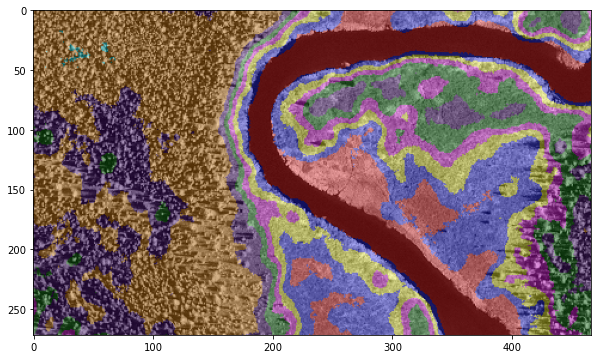

In [20]:
# In progress...
# Eventually add entropy and texture metrics to raster stack for classification

import matplotlib.pyplot as plt
from skimage.filters.rank import entropy
from skimage.morphology import disk

entr_img = entropy(ndvi, disk(10))

# View the segments via Python
plt.figure(figsize=(10,10))
plt.imshow(color.label2rgb(entr_img, img))

# Also try Gabor Filter Banks
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_gabor.html

# And GLCM Texture Features
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html
#glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
#                    symmetric=True, normed=True)